<a href="https://colab.research.google.com/github/joaopmatos/Notally/blob/master/DeepLearning_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the data

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. Load Dataset (Ensure you upload 'diabetes.csv' to Colab)
url = "/content/drive/MyDrive/Recursos/EDIT/Data Science and Business Analytics/Módulo 9/diabetes.csv"
df = pd.read_csv(url)

# Checking the quality of the data

In [46]:
pip install ydata-profiling

In [70]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Diabetes Dataset Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 80.94it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Several columns contain a huge amount of zeros in places where it's unreasonable to see it as valid, e.g BMI, Glucose, BLoodPressure.
As a general rule of thumb, one of the possible approcahes is to replace the missing values with the median, so we'll do that.

In [72]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

In [73]:
# Calculate the amount of columns with zeros
(df[cols_with_zeros] == 0).sum()

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

# Splitting the data, normalizing features
Given that we'll train a neural network, we must scale the features.

In [50]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Running the tree based model

In [75]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
#Let's evaluate the performance of the random forest
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



## Let's try to improve the performance

In [54]:
#Hyperparameter tuning for the random forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5,10,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3,5,10,20],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [55]:
#Evaluate the best random forest
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [63]:
#Run the random forest with the best_rf
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.82       100
           1       0.67      0.54      0.60        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



## Funny enough, slightly worse performance!

### Let's see the performance of the best one in more detail

In [76]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
#Let's evaluate the performance of the random forest
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



Text(0.5, 1.0, 'Confusion Matrix')

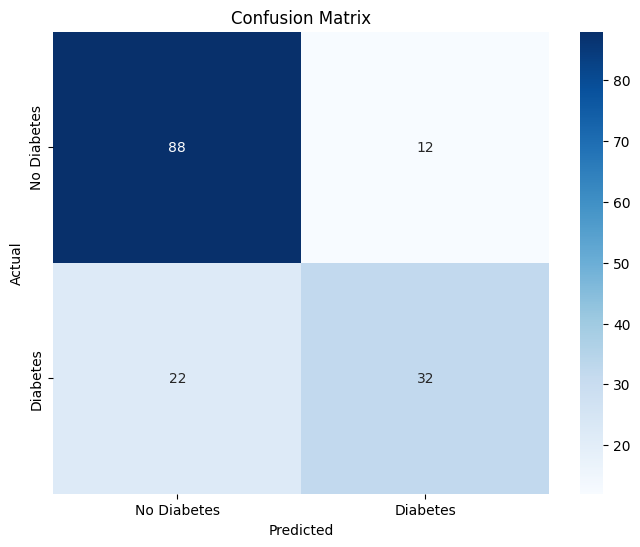

In [79]:
#Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes','Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

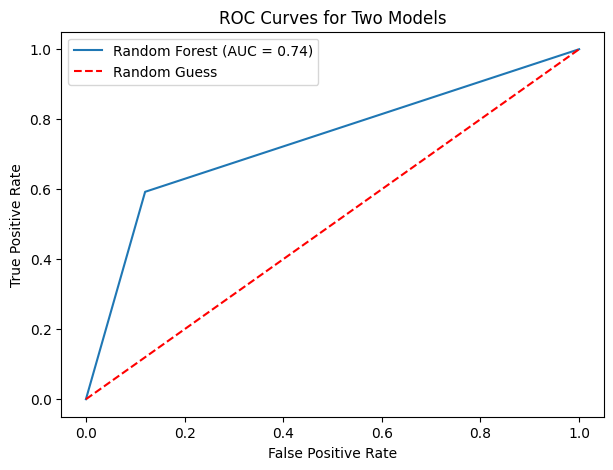

In [81]:
#Plot the AUC
from sklearn.metrics import roc_curve, auc
test_df = pd.DataFrame(
    {'True': y_test, 'RandomForest': y_pred})

plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(test_df['True'], test_df['RandomForest'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

# Now, let's prepare the neural network

In the output layer we'll have a sigmoid given that this is a classification problem

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# ANN Architecture
ann_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(8, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 8. Train Model [cite: 56]
history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4879 - loss: 0.8135 - val_accuracy: 0.6260 - val_loss: 0.6541
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5163 - loss: 0.8395 - val_accuracy: 0.6667 - val_loss: 0.6274
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5843 - loss: 0.7512 - val_accuracy: 0.6748 - val_loss: 0.6038
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6128 - loss: 0.6998 - val_accuracy: 0.6911 - val_loss: 0.5810
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6412 - loss: 0.6827 - val_accuracy: 0.6992 - val_loss: 0.5638
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6591 - loss: 0.6570 - val_accuracy: 0.7073 - val_loss: 0.5489
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6765 - loss: 0.6162 - val_accuracy: 0.7480 - val_loss: 0.5376
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6758 - loss: 0.5938 - val_accuracy: 0.7642 - val_los

In [89]:
#Let's measure the performance of the neural network
y_pred_ann = ann_model.predict(X_test_scaled)

y_pred_ann = (y_pred_ann > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [90]:
#Comparing the performance of the random forest and the neural network
print("Random Forest Performance:")
print(classification_report(y_test, y_pred))
print("\nNeural Network Performance:")
print(classification_report(y_test, y_pred_ann))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


Neural Network Performance:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       100
           1       0.58      0.52      0.55        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



## Let's try to improve recall given that this is a health related prediction

In [91]:
#Let's measure the performance of the neural network
y_pred_ann = ann_model.predict(X_test_scaled)

y_pred_ann = (y_pred_ann > 0.8).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [92]:
#Comparing the performance of the random forest and the neural network
print("Random Forest Performance:")
print(classification_report(y_test, y_pred))
print("\nNeural Network Performance:")
print(classification_report(y_test, y_pred_ann))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


Neural Network Performance:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81       100
           1       0.90      0.17      0.28        54

    accuracy                           0.70       154
   macro avg       0.79      0.58      0.55       154
weighted avg       0.76      0.70      0.63       154



Changing the threshold for the sigmoid makes it so we actually get much better recall with a tolerable sacrifice to accuracy. This would seem like a fair trade off.

Let's try to improve the performance of the neural network

In [93]:
# ANN Architecture
ann_model_no_dropout = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),

    Dense(200, activation='relu'),
    BatchNormalization(),

    Dense(50, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

ann_model_no_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 7. Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 8. Train Model [cite: 56]
history = ann_model_no_dropout.fit(
    X_train_scaled, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.5370 - loss: 0.8082 - val_accuracy: 0.7154 - val_loss: 0.6487
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7718 - loss: 0.5020 - val_accuracy: 0.7561 - val_loss: 0.6352
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7611 - loss: 0.4938 - val_accuracy: 0.7236 - val_loss: 0.6323
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7972 - loss: 0.4358 - val_accuracy: 0.7642 - val_loss: 0.6152
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7716 - loss: 0.4538 - val_accuracy: 0.7642 - val_loss: 0.5978
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8197 - loss: 0.3944 - val_accuracy: 0.7967 - val_loss: 0.5857
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8062 - loss: 0.3947 - val_accuracy: 0.7724 - val_loss: 0.5750
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8182 - loss: 0.3784 - val_accuracy: 0

In [94]:
#Let's measure the performance of the neural network
y_pred_ann_no_dropout = ann_model_no_dropout.predict(X_test_scaled)

y_pred_ann_no_dropout = (y_pred_ann_no_dropout > 0.7).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [95]:
#Comparing the performance of the random forest and the neural network
print("Random Forest Performance:")
print(classification_report(y_test, y_pred))
print("\nNeural Network Performance:")
print(classification_report(y_test, y_pred_ann))
print("\nNeural Network Performance, no dropout:")
print(classification_report(y_test, y_pred_ann_no_dropout))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154


Neural Network Performance:
              precision    recall  f1-score   support

           0       0.69      0.99      0.81       100
           1       0.90      0.17      0.28        54

    accuracy                           0.70       154
   macro avg       0.79      0.58      0.55       154
weighted avg       0.76      0.70      0.63       154


Neural Network Performance, no dropout:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       100
           1       0.71      0.31      0.44        54

    accuracy                           0.71       154
   macro avg       0.71      0.

#Results
## Random Forest
``` python
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154
```
## Neural Network
``` python
              precision    recall  f1-score   support

           0       0.69      0.99      0.81       100
           1       0.90      0.17      0.28        54

    accuracy                           0.70       154
   macro avg       0.79      0.58      0.55       154
weighted avg       0.76      0.70      0.63       154
```
## Neural Network, no dropout, more layers and neurons
``` python
Neural Network Performance, no dropout:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81       100
           1       0.71      0.31      0.44        54

    accuracy                           0.71       154
   macro avg       0.71      0.62      0.62       154
weighted avg       0.71      0.71      0.68       154
```

### Which model performed best?
Out of all three, I'd say the first Neural Network. In a scenario that is health focused. We always desire to maximize for recall. Given this goal for safe health prediction outcomes, clearly that on stands out.

### Did your ANN overfit?
My second ANN seemed to overfit. The accuracy kept increasing, but the val_accuracy stopped.

### Which technique was most helpful?
Given that th first neural network performed best, dropout played a huge role in improving the generalization. Despite the accuracy improvement, the performance with the test decreased.

### How would the results change with more data?
We'd be able to do more learning without risking overfitting, leading, naturally, to a better performing ANN. The Random forest would still benefit from it, but the ANN is particularly sensistive to this need.

# Bonus: SHAP values!

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  0%|          | 0/154 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
4874/4874 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

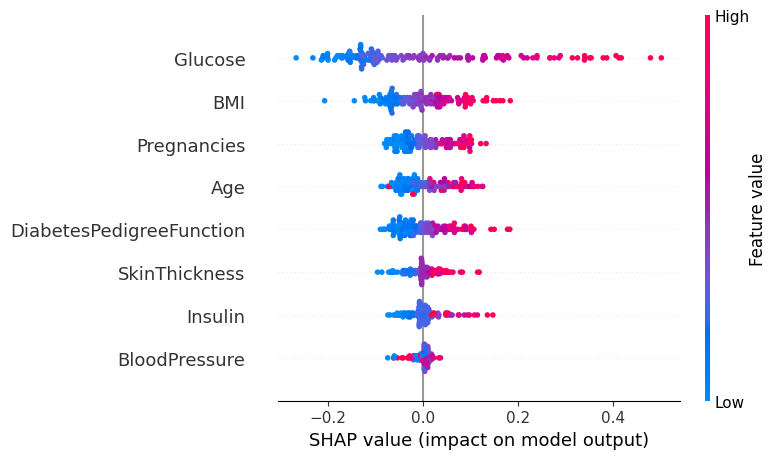

In [97]:
import shap

# Initialize JS for SHAP plots
shap.initjs()

# Use X_train_scaled for the background data for KernelExplainer
# Explicitly get the probability for the positive class and flatten it to (num_samples,)
explainer = shap.KernelExplainer(lambda x: ann_model.predict(x)[:, 0], X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Create a summary plot for the SHAP values using feature names from X_test
# Now shap_values will be a single 2D array (num_samples, num_features)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns.tolist())